In [20]:
!pip install pydicom
!pip install opencv-python
!pip install imgaug
!pip install h5py==2.10.0
!pip install keras==2.1.6
!pip install pandas
!pip install seaborn

     |████████████████████████████████| 283 kB 1.4 MB/s eta 0:00:01


In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.3


In [21]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
import seaborn as sn
import pandas as pd


IMAGE_SIDE = 1024

In [5]:
# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [6]:
ROOT_DIR = '/home/ubuntu/data'
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')
DICOM_DIR = os.path.join(ROOT_DIR, 'stage_2_train_images')
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')

In [7]:
lables = pd.read_csv(os.path.join(ROOT_DIR, 'stage_2_train_labels.csv'))
image_files = glob.glob(DICOM_DIR+'/'+'*.dcm')
image_annotations = {fp: [] for fp in image_files}
for index, row in lables.iterrows():
  fp = os.path.join(DICOM_DIR, row['patientId']+'.dcm')
  image_annotations[fp].append(row)

DETECTOR CONFIG

In [8]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 2
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 100
    
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      2
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

DETECTOR DATASET

In [9]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

DATA SPLIT INTO TRAIN AND VALIDATION

In [10]:
sorted(image_files)
random.seed(0)
random.shuffle(image_files)

train_image_count = int(0.8 * len(image_files))
train_image_files = image_files[:train_image_count]
val_image_files = image_files[train_image_count:]

In [11]:
dataset_train = DetectorDataset(train_image_files, image_annotations, IMAGE_SIDE, IMAGE_SIDE)
dataset_train.prepare()

In [12]:
dataset_val = DetectorDataset(val_image_files, image_annotations, IMAGE_SIDE, IMAGE_SIDE)
dataset_val.prepare()

In [13]:
print(f"Train size: {len(train_image_files)}, Validation size: {len(val_image_files)}")

Train size: 21347, Validation size: 5337


TRAINING MODEL

In [14]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.02)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

/home/ubuntu/miniconda3/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [16]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)
# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", 
                                                             "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])
#model.load_weights('/home/ubuntu/data/logs/pneumonia20201217T0756/mask_rcnn_pneumonia_0011.h5')
#hack to prevent an error
model.keras_model.metrics = []






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.






Re-starting from epoch 11


In [17]:
NUM_EPOCHS = 30

# Train Mask-RCNN Model 
import warnings 
model.keras_model.metrics
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all',
           augmentation=augmentation)


Starting at epoch 11. LR=0.001

Checkpoint Path: /home/ubuntu/data/logs/pneumonia20201217T0756/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_br

In [15]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=MODEL_DIR)
model.load_weights('/home/ubuntu/data/logs/pneumonia20201217T0756/mask_rcnn_pneumonia_0014.h5', by_name = True)
#model.load_weights('/home/ubuntu/data/logs/mask_rcnn_coco.h5')







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.






Re-starting from epoch 14


In [16]:
fp = 0
tp = 0
fn = 0
tn = 0
correct = 0
for image_id in dataset_val.image_ids:
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
    result = model.detect([image])[0]
    orig_class = 0 if len(class_ids) == 0 else 1
    predicted_class = 0 if len(result['rois']) == 0 or max(result['scores']) < .98 else 1
    if orig_class == predicted_class:
        correct = correct + 1
    if orig_class == 0 and predicted_class == 1:
        fp = fp + 1
    if orig_class == 0 and predicted_class == 0:
        tn = tn + 1
    if orig_class == 1 and predicted_class == 0:
        fn = fn + 1
    if orig_class == 1 and predicted_class == 1:
        tp = tp + 1
    if (1 + image_id) % 100 == 0:
        print("Correct:", correct, "Total:", image_id, "Correct %", correct*100.0/(1 + image_id), "%")
        print("tp", tp, "fp", fp)
        print("tn", tn, "fn", fn)
        print("=================")

Correct: 75 Total: 99 Correct % 75.0 %
tp 5 fp 6
tn 70 fn 19
Correct: 153 Total: 199 Correct % 76.5 %
tp 15 fp 12
tn 138 fn 35
Correct: 229 Total: 299 Correct % 76.33333333333333 %
tp 24 fp 20
tn 205 fn 51
Correct: 301 Total: 399 Correct % 75.25 %
tp 32 fp 26
tn 269 fn 73
Correct: 380 Total: 499 Correct % 76.0 %
tp 40 fp 33
tn 340 fn 87
Correct: 456 Total: 599 Correct % 76.0 %
tp 45 fp 42
tn 411 fn 102
Correct: 537 Total: 699 Correct % 76.71428571428571 %
tp 54 fp 51
tn 483 fn 112
Correct: 609 Total: 799 Correct % 76.125 %
tp 58 fp 59
tn 551 fn 132
Correct: 684 Total: 899 Correct % 76.0 %
tp 71 fp 68
tn 613 fn 148
Correct: 764 Total: 999 Correct % 76.4 %
tp 80 fp 72
tn 684 fn 164
Correct: 841 Total: 1099 Correct % 76.45454545454545 %
tp 91 fp 80
tn 750 fn 179
Correct: 918 Total: 1199 Correct % 76.5 %
tp 97 fp 85
tn 821 fn 197
Correct: 997 Total: 1299 Correct % 76.6923076923077 %
tp 104 fp 94
tn 893 fn 209
Correct: 1080 Total: 1399 Correct % 77.14285714285714 %
tp 112 fp 99
tn 968 fn 22

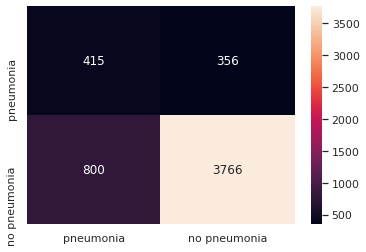

In [31]:
array = [[tp, fp],
         [fn, tn]]

df = pd.DataFrame(array, ['pneumonia', 'no pneumonia'], ['pneumonia', 'no pneumonia'])
sn.heatmap(df, annot=True, fmt ='d') # font size

plt.show()


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



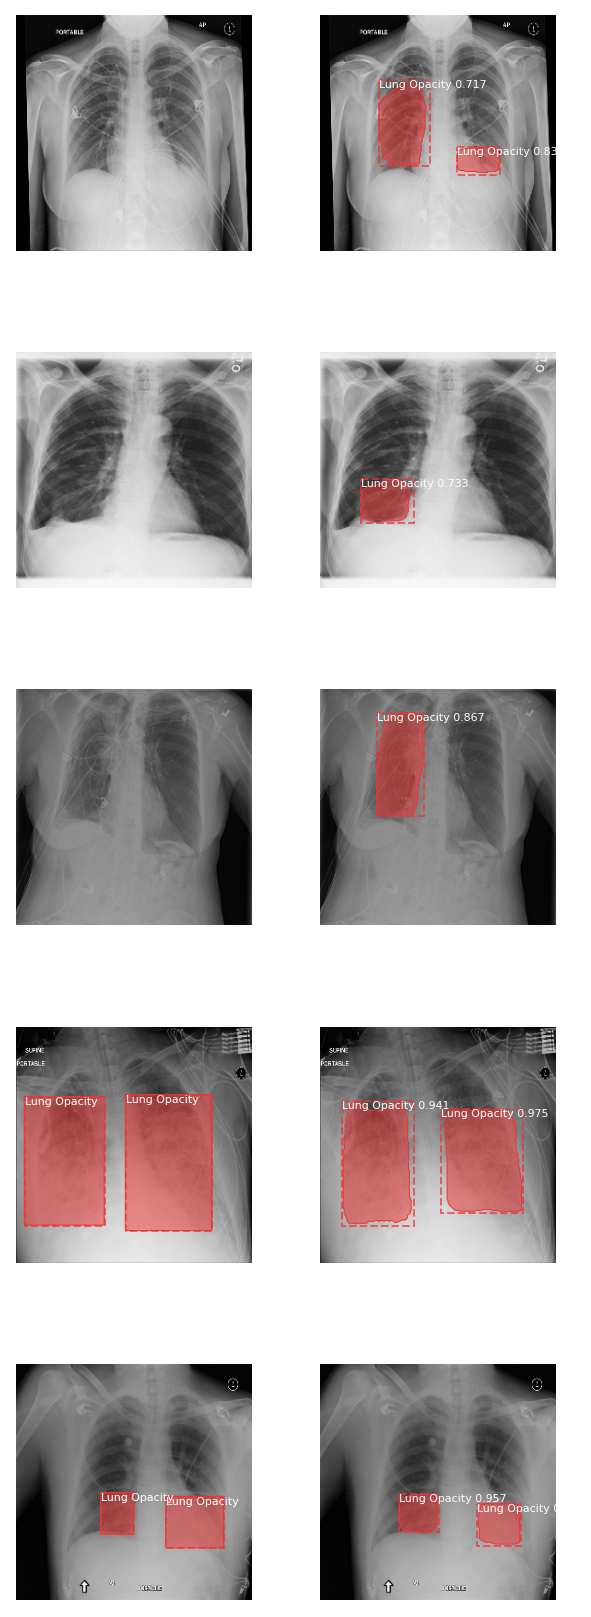

In [33]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(5):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    plt.subplot(5, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(5, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])